<a href="https://colab.research.google.com/github/irdinajaswan/deeplearning_lastproject/blob/main/houseprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

fed_files = ["MORTGAGE30US.csv", "RRVRUSQ156N.csv", "CPIAUCSL.csv"]

dfs = [pd.read_csv(f, parse_dates=True, index_col=0) for f in fed_files]

Loading the files

In [3]:
fed_data = pd.concat(dfs, axis=1)

In [4]:
fed_data = fed_data.ffill().dropna()

Reading Zillow data

In [5]:
zillow_files = ["Metro_median_sale_price_uc_sfrcondo_week.csv", "Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_month.csv"]

dfs = [pd.read_csv(f) for f in zillow_files]

In [6]:
dfs = [pd.DataFrame(df.iloc[0,5:]) for df in dfs]
for df in dfs:
    df.index = pd.to_datetime(df.index)
    df["month"] = df.index.to_period("M")

In [7]:
price_data = dfs[0].merge(dfs[1], on="month")

In [8]:
price_data.index = dfs[0].index

In [9]:
del price_data["month"]
price_data.columns = ["price", "value"]

In [10]:
from datetime import timedelta

fed_data.index = fed_data.index + timedelta(days=2)

In [11]:
fed_data.tail(20)

,MORTGAGE30US,RRVRUSQ156N,CPIAUCSL
DATE,,,
2023-08-05,6.90,6.6,306.269
2023-08-12,6.96,6.6,306.269
2023-08-19,7.09,6.6,306.269
2023-08-26,7.23,6.6,306.269
2023-09-02,7.18,6.6,306.269
2023-09-03,7.18,6.6,307.481
2023-09-09,7.12,6.6,307.481
2023-09-16,7.18,6.6,307.481
2023-09-23,7.19,6.6,307.481


In [12]:
price_data = fed_data.merge(price_data, left_index=True, right_index=True)

In [13]:
price_data.columns = ["interest", "vacancy", "cpi", "price", "value"]


In [14]:
price_data

,interest,vacancy,cpi,price,value
2008-02-02,5.68,10.1,212.174,190000.0,206885.853266
2008-02-09,5.67,10.1,212.687,190000.0,206885.853266
2008-02-16,5.72,10.1,212.687,193000.0,206885.853266
2008-02-23,6.04,10.1,212.687,189900.0,206885.853266
2008-03-01,6.24,10.1,212.687,194900.0,205459.521952
...,...,...,...,...,...
2022-06-11,5.23,5.6,294.728,370000.0,357473.327397
2022-06-18,5.78,5.6,294.728,375000.0,357473.327397
2022-06-25,5.81,5.6,294.728,370000.0,357473.327397
2022-07-02,5.70,5.6,294.728,370000.0,357107.271636


In [15]:
price_data["adj_price"] = price_data["price"] / price_data["cpi"] * 100
price_data["adj_value"] = price_data["value"] / price_data["cpi"] * 100

<Axes: >

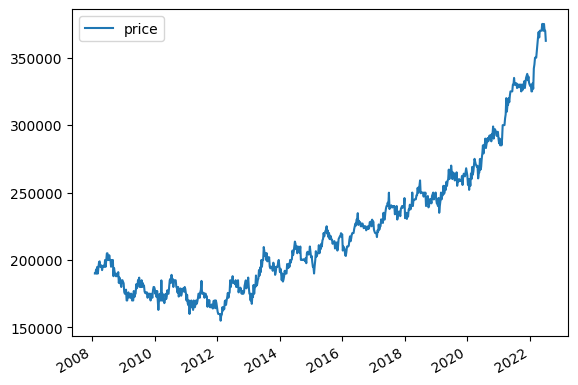

In [16]:
price_data.plot.line(y="price", use_index=True)

<Axes: >

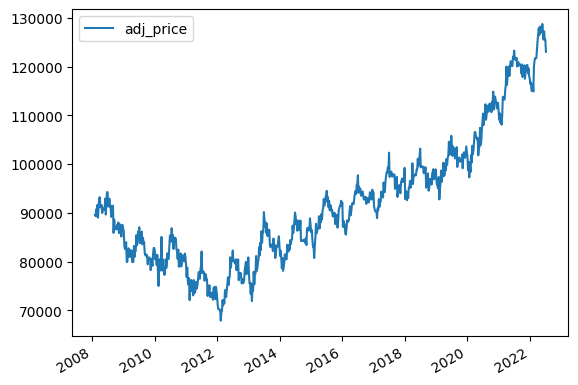

In [17]:
price_data.plot.line(y="adj_price", use_index=True)

In [18]:
price_data["next_quarter"] = price_data["adj_price"].shift(-13)

In [19]:
price_data.dropna(inplace=True)

In [20]:
price_data["change"] = (price_data["next_quarter"] > price_data["adj_price"]).astype(int)

In [21]:
price_data["change"].value_counts()

1    376
0    346
Name: change, dtype: int64

In [22]:
predictors = ["interest", "vacancy", "adj_price", "adj_value"]
target = "change"

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

START = 260
STEP = 52

def predict(train, test, predictors, target):
    rf = RandomForestClassifier(min_samples_split=10, random_state=1)
    rf.fit(train[predictors], train[target])
    preds = rf.predict(test[predictors])
    return preds

def backtest(data, predictors, target):
    all_preds = []
    for i in range(START, data.shape[0], STEP):
        train = price_data.iloc[:i]
        test = price_data.iloc[i:(i+STEP)]
        all_preds.append(predict(train, test, predictors, target))

    preds = np.concatenate(all_preds)
    return preds, accuracy_score(data.iloc[START:][target], preds)

In [24]:
preds, accuracy = backtest(price_data, predictors, target)

In [25]:
preds

array([1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [26]:
accuracy

0.5887445887445888

In [27]:
yearly = price_data.rolling(52, min_periods=1).mean()

In [28]:
yearly_ratios = [p + "_year" for p in predictors]
price_data[yearly_ratios] = price_data[predictors] / yearly[predictors]


In [29]:
price_data

,interest,vacancy,cpi,price,value,adj_price,adj_value,next_quarter,change,interest_year,vacancy_year,adj_price_year,adj_value_year
2008-02-02,5.68,10.1,212.174,190000.0,206885.853266,89549.143627,97507.636782,90610.014498,1,1.000000,1.000000,1.0,1.0
2008-02-09,5.67,10.1,212.687,190000.0,206885.853266,89333.151533,97272.448841,90563.547824,1,0.999119,1.000000,0.998793,0.998793
2008-02-16,5.72,10.1,212.687,193000.0,206885.853266,90743.674978,97272.448841,91014.739229,1,1.005272,1.000000,1.009662,0.999195
2008-02-23,6.04,10.1,212.687,189900.0,206885.853266,89286.134084,97272.448841,90610.014498,1,1.045435,1.000000,0.995075,0.999396
2008-03-01,6.24,10.1,212.687,194900.0,205459.521952,91637.006493,96601.824254,92933.348203,1,1.063032,1.000000,1.016948,0.993996
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-12,3.85,5.8,287.472,350000.0,344042.433111,121750.987922,119678.58891,125539.48047,1,1.235955,0.977317,1.022014,1.050166
2022-03-19,4.16,5.8,287.472,350000.0,344042.433111,121750.987922,119678.58891,127235.959936,1,1.326140,0.980494,1.020613,1.048017
2022-03-26,4.42,5.8,287.472,355000.0,344042.433111,123490.28775,119678.58891,125539.48047,1,1.397289,0.983692,1.033486,1.045877
2022-04-02,4.67,5.8,287.472,360000.0,350515.841789,125229.587577,121930.428629,125539.48047,1,1.462275,0.986911,1.046342,1.062983


In [30]:
accuracy

0.5887445887445888

In [31]:
pred_match = (preds == price_data[target].iloc[START:])
pred_match[pred_match == True] = "pink"
pred_match[pred_match == False] = "blue"

<Axes: xlabel='index', ylabel='adj_price'>

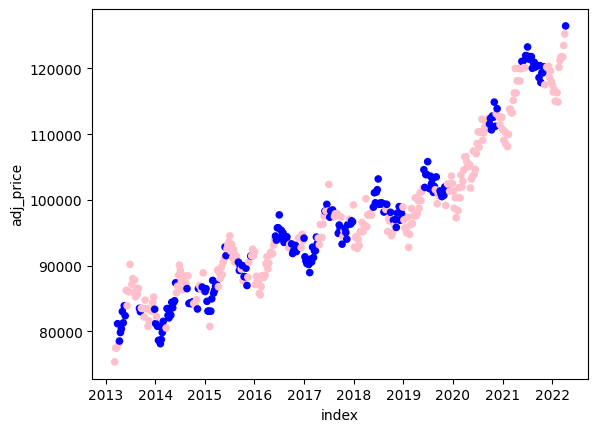

In [32]:
import matplotlib.pyplot as plt

plot_data = price_data.iloc[START:].copy()

plot_data.reset_index().plot.scatter(x="index", y="adj_price", color=pred_match)


In [33]:
from sklearn.inspection import permutation_importance

rf = RandomForestClassifier(min_samples_split=10, random_state=1)
rf.fit(price_data[predictors], price_data[target])

result = permutation_importance(rf, price_data[predictors], price_data[target], n_repeats=10, random_state=1)

In [34]:
result["importances_mean"]

array([0.17160665, 0.15498615, 0.2699446 , 0.33379501])

In [35]:
predictors


['interest', 'vacancy', 'adj_price', 'adj_value']